In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import integrate
from scipy import sparse
import torch 
from torch import nn
from tqdm import tqdm
from torch.autograd import grad

import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from utils_physics import *
from dsm import *
from pinn import *

In [3]:
! echo $CUDA_VISIBLE_DEVICES

0


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Let's define some variables like dimension, mass $m$, the initial phase $S_0(x)$, etc.

In [5]:
T = 1 # time [0, T]
N = 1000 # split [0, T] into N+1 parts
h = 1e-2 
m = 1
s0_phase = 0
sig2 = np.sqrt(0.1)
mu = 0

d = 1 #3 # points from R^d

In [6]:
time_splits = torch.Tensor(np.linspace(0, T, N+1))

## Our approach

Let's define some hyperparameters such as lr, and train our model.

In [7]:
dim_inp = d + 1
dim_out = d
dim_hid = 200 # 200 
net_u = NN(dim_inp, dim_hid, dim_out).to(device);
net_v = NN(dim_inp, dim_hid, dim_out).to(device);

learning_rate = 1e-4

optimizer = torch.optim.Adam([*net_u.parameters(), *net_v.parameters()], lr=learning_rate, weight_decay=0) 

alpha = 0.8  # Score loss
beta = 1 # Newton loss
gamma = 1 # IC loss

In [8]:
NUM_EPOCHS = 4000

net_u, net_v, losses, losses_sm, losses_newton, losses_init = train_dsm(net_u, net_v, d, mu, sig2, device,
                                                                        optimizer, time_splits,
              batch_size=100, n_iter=NUM_EPOCHS, N=N, iter_threshhold=4, 
              alpha_later=0.2, alpha_start=0.6, 
              use_Laplacian=False, x0_phase=s0_phase)

100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [47:35<00:00,  1.40iter/s, loss_iter=2.21e-5, loss_mean=2.82e-5, loss_std=3.13e-6]


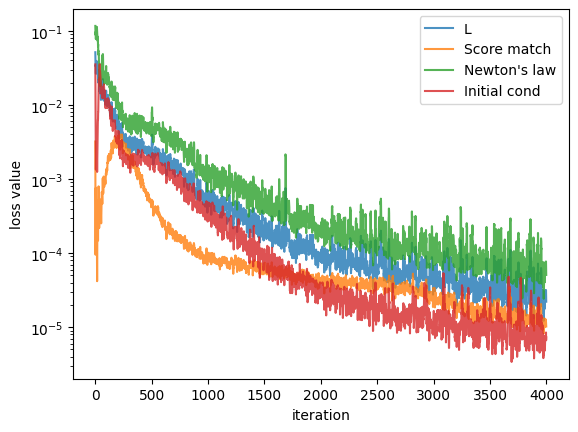

In [9]:
plt.plot(losses, alpha=0.8, label='L')
plt.plot(losses_sm, alpha=0.8,  label='Score match')
plt.plot(losses_newton, alpha=0.8,  label='Newton\'s law')
plt.plot(losses_init, alpha=0.8,  label='Initial cond')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.yscale('log')
plt.legend();

In [11]:
torch.save(net_u.to('cpu'), 'net_u_osc_{}d_{}k_ep_noLap.pth'.format(d, NUM_EPOCHS))
torch.save(net_v.to('cpu'), 'net_v_osc_{}d_{}k_ep_noLap.pth'.format(d, NUM_EPOCHS))
net_u.to(device), net_v.to(device);

In [9]:
# net_u = torch.load('../net_u_osc_{}d_{}k_ep_noLap.pth') 
# net_v = torch.load('../net_v_osc_{}d_{}k_ep_noLap.pth') 
# net_u.to(device), net_v.to(device);

#### Sample with NN

In [12]:
net_u.eval();
net_v.eval();

samples = 10000
T = 1
N = 1000
num_trials = 10
X_test = np.zeros((num_trials, N+1, samples, d))

nu_s = 1

for trial in range(num_trials):
    with torch.no_grad():
        X_0 = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, (sig2**2)*np.eye(d), samples)).to(device)
        X_test[trial, 0, :] = X_0.cpu().numpy()
        X_prev = X_0.clone()
        eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), samples) for i in range(N)]    
        for i in range(1, N+1):
            a = torch.hstack((X_prev, time_splits[i-1].expand(samples, 1).to(device)))
            X_i = torch.Tensor(X_prev).to(device) + T / N * \
            (nu_s * net_u(X_prev, time_splits[i-1].expand(samples, 1).to(device)) \
             + net_v(X_prev, time_splits[i-1].expand(samples, 1).to(device))) \
                       + torch.Tensor(np.sqrt((h*T * nu_s)/(m*N)) * eps[i-1]).to(device)
            X_test[trial, i, :] = X_i.cpu().numpy()
            X_prev = X_i.clone()

In [13]:
mean_trials = np.zeros((num_trials, N + 1, d))
var_trials = np.zeros((num_trials, N + 1, d))

for trial in range(num_trials):
    mean_trials[trial] = X_test[trial].mean(axis=1)
    var_trials[trial] = X_test[trial].var(axis=1)

### Numerical solution and visualization

Let's get the numerical solution and visualize some observables -- the mean of $X_t$ and the variance of $X_t$.

In [14]:
sol, bmeans, bstds = find_num_solution(sig2, time_splits, x0_phase=s0_phase, dx=np.sqrt(1 / 20000))

In [15]:
dens_num = np.abs(sol)**2

Let's visualize the statistics.

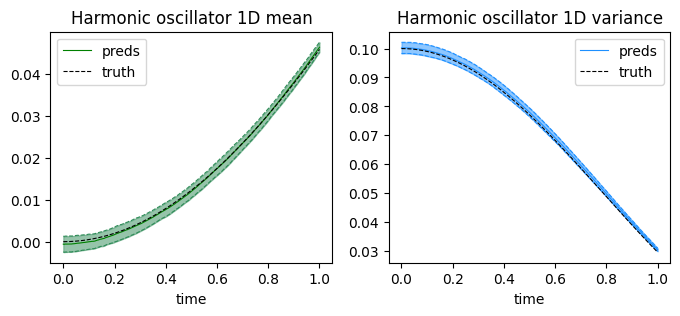

In [12]:
i = 0
plot_stats(time_splits, mean_trials[:, :, i], var_trials[:, :, i], time_splits, bmeans, bstds)

## PINNs approach

In [17]:
#  Doman bounds
lb = np.array([-2.0, 0.0])
ub = np.array([2.0, 1])

# number of IC points and BC points
N0 = 1000
N_b = 300
# number of collocation points
# N_f = 100000
N_f = 60000

delta_x = np.sqrt(1/20000)
x = np.arange(lb[0], ub[0], delta_x).astype(float)[:,None]
t = np.linspace(0, 1, 1000+1).astype(float)[:,None]
print(x.shape, t.shape)

X, T = np.meshgrid(x, t)
X_test_pinn = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
print(X_test_pinn.shape)

(566, 1) (1001, 1)
(566566, 2)


In [18]:
# getting IC points for training 
x_init_grid = np.arange(lb[0], ub[0], np.sqrt(1/80000)).astype(float)
sol_0 = psi_0(x_init_grid)
u_sol_0 = np.real(sol_0)
v_sol_0 = np.imag(sol_0)

idx_x = np.random.choice(u_sol_0.shape[0], N0, replace=False)
x0 = x_init_grid[idx_x, None] # need for training
ic_val = np.hstack((x0, np.zeros_like(x0)))
u0 = u_sol_0[idx_x, None]
v0 = v_sol_0[idx_x, None]
ic_sol = np.hstack((u0, v0)) # need for training


# getting BC points 
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :] # need for training
b_val_l = np.hstack((np.ones_like(tb)[:len(tb)//2]* lb[0], tb[:len(tb)//2]))
b_val_r = np.hstack((np.ones_like(tb)[len(tb)//2:]* ub[0], tb[len(tb)//2:]))
b_val = np.concatenate((b_val_l, b_val_l), axis=0) # need for training

# getting collocation points
X_f = lb + (ub - lb) * lhs(2, N_f)

In [19]:
X_f = torch.tensor(X_f).float().requires_grad_(True)
ic_val = torch.tensor(ic_val).float()#.requires_grad_(False)
ic_sol = torch.tensor(ic_sol).float()#.requires_grad_(False)
b_val = torch.tensor(b_val).float()#.requires_grad_(False)

We have the equation
$$i h \Psi_t + \frac{h^2}{2m} \Psi_{xx} - V(x) \Psi = 0. $$
​
Let $\Psi = u + i v,$ then we have 
$$i h (u_t + i v_t) + \frac{h^2}{2m} (u_{xx} + i v_{xx}) - V(x) (u + i v) = 0, $$
$$ih u_t - h v_t + \frac{h^2}{2m} u_{xx} + i \frac{h^2}{2m} v_{xx} - V(x)u - i V(x) v = 0$$
$$\big(- h  v_t + \frac{h^2}{2m} u_{xx} - V(x)u\big) + i \big(h u_t + \frac{h^2}{2m} v_{xx} -  V(x)v\big) = 0. $$
It's $L_f $ loss.

In [52]:
n_epochs = 120000 # 10
model_pinn = NN_PINN(2, 400, 2).to(device)
model_pinn, loss_pinn, loss_regr, l_physics, l_bc, loss_ic = train_pinn(model_pinn, n_epochs,
                                                             X_f, b_val, ic_val, ic_sol, device,
                                                             sample_idx=True)

  6%|████▏                                                               | 7479/120000 [06:35<1:35:36, 19.61epoch/s, loss_iter=0.000445, loss_mean=7.04e-8, loss_std=8.28e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|███████▍                                                            | 13022/120000 [11:26<1:36:08, 18.55epoch/s, loss_iter=0.000115, loss_mean=2.24e-8, loss_std=2.4e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%

In [8]:
# plt.plot(loss_pinn, label='loss')
# # plt.plot(loss_regr, label='loss MSE')
# plt.plot(l_physics, label='L_f')
# plt.plot(l_bc, label='L_bc')
# plt.plot(loss_ic, label='L_ic')
# plt.legend()
# plt.yscale('log');

In [104]:
# checkpoint = torch.load('../pics/pinn_1d_checkp.pth')
# # load model weights state_dict
# model_pinn.load_state_dict(checkpoint['model_state_dict'])
# model_pinn.to(device)
# model_pinn.eval();

In [54]:
delta_x = np.sqrt(1/20000)
x_pinn = np.arange(lb[0], ub[0], delta_x).astype(float)[:,None]
X, T = np.meshgrid(x_pinn, time_splits)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
print(X_star.shape)

(566566, 2)


In [55]:
model_pinn.eval();
with torch.no_grad():
    y_pred = model_pinn(torch.tensor(X_star).float().to(device))

In [56]:
dens_pinn = get_dens_pinn(y_pred.cpu().numpy(), num_t=1001, num_x=X_star.shape[0]//1001)

In [57]:
bmeans_pinn = []
bstds_pinn = []

for i, time in enumerate(time_splits):
    bmeans_pinn.append(np.dot(x_pinn[:, 0], delta_x * dens_pinn[i, :])) 
    
    bstds_pinn.append(np.dot((x_pinn[:, 0] - bmeans_pinn[-1]) ** 2, delta_x * dens_pinn[i, :]))

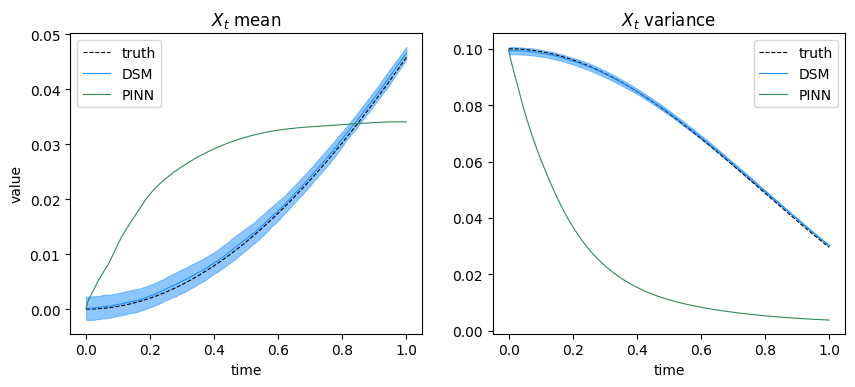

In [182]:
make_our_pinn_stats_plot(time_splits, bmeans, bstds, 
                             mean_trials[:, :, i], var_trials[:, :, i],
                             bmeans_pinn, bstds_pinn)

In [60]:
x = np.arange(lb[0], ub[0], np.sqrt(1/20000)).astype(float)
x_half = x.shape[0]//2
k = 43

n_bins = len(x)
p = np.zeros((len(time_splits), n_bins))
for i in range(len(time_splits)):
    p[i, :] = np.histogram(X_test[:, i, :, 0].reshape(-1), 
                           density=True, bins=n_bins, range=(-2, 2))[0]

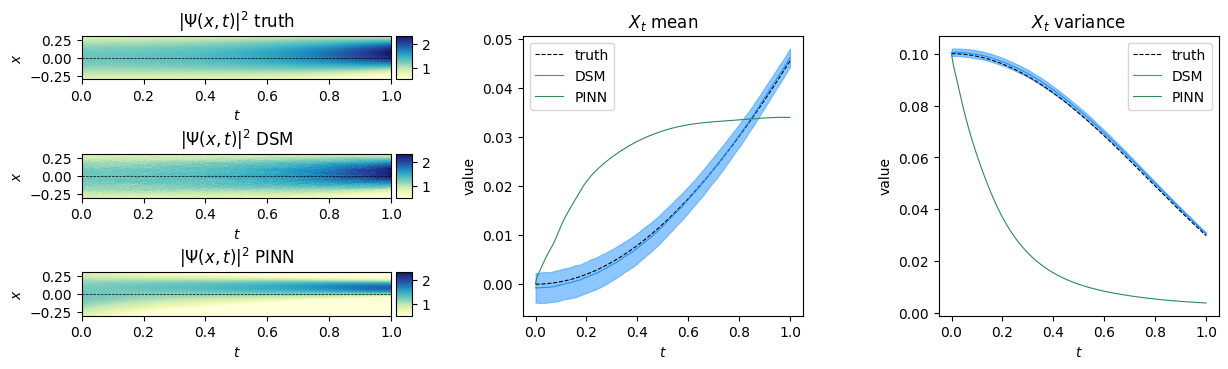

In [228]:
i = 0
fig = plt.figure(figsize=(15, 4))  
# gs0 = gridspec.GridSpec(6, 5)
gs0 = gridspec.GridSpec(3, 6)
# gs0.update(top=0.9, bottom=0.4, wspace=1.2, hspace=20)
gs0.update(top=0.9, bottom=0.2, wspace=0.7, hspace=1.7)
# gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs0[1-1, :2])
ax2 = plt.subplot(gs0[2-1, :2])
ax3 = plt.subplot(gs0[3-1, :2])
ax4 = plt.subplot(gs0[:3, 2:4])
ax5 = plt.subplot(gs0[:3, 4:6])

h_1 = ax1.axhline(0, linestyle='--', color='black', linewidth=0.5)
h_1 = ax1.imshow(dens_num.T[x_half-k: x_half+k, :], cmap='YlGnBu', interpolation='nearest', 
              extent=[lb[1], ub[1], x[x_half-k], x[x_half+k]], 
              origin='lower', aspect='auto', vmin=0.5, vmax=2.33)

# h_.clim(0, 1.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_1, cax=cax)

# ax.set_ylim(-0.3, 0.3)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_title('$|\Psi(x, t)|^2$ truth');


h_2 = ax2.axhline(0, linestyle='--', color='black', linewidth=0.5)
h_2 = ax2.imshow(p.T[x_half-k: x_half+k, :], cmap='YlGnBu', interpolation='nearest', 
              extent=[lb[1], ub[1], x[x_half-k], x[x_half+k]], 
              origin='lower', aspect='auto', vmin=0.5, vmax=2.33)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_2, cax=cax)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x$')
ax2.set_title('$|\Psi(x, t)|^2$ DSM');

h_3 = ax3.axhline(0, linestyle='--', color='black', linewidth=0.5)
h_3 = ax3.imshow(dens_pinn.T[x_half-k: x_half+k, :], cmap='YlGnBu', interpolation='nearest', 
              extent=[lb[1], ub[1], x[x_half-k], x[x_half+k]], 
              origin='lower', aspect='auto', vmin=0.5, vmax=2.33)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_3, cax=cax)
ax3.set_ylabel('$x$')
ax3.set_xlabel('$t$')
ax3.set_title('$|\Psi(x, t)|^2$ PINN');

h_4 = ax4.plot(time_splits, bmeans, color='black', linestyle='--', label='truth', linewidth=0.8)
h_4 = ax4.plot(time_splits, mean_trials[:, :, i].mean(axis=0), color='dodgerblue', label='DSM', linewidth=0.8)
h_4 = ax4.fill_between(time_splits, mean_trials[:, :, i].mean(axis=0) - mean_trials[:, :, i].std(axis=0), 
                    mean_trials[:, :, i].mean(axis=0) + mean_trials[:, :, i].std(axis=0), color='dodgerblue', 
                    alpha=0.5, linewidth=0.8)
h_4 = ax4.plot(time_splits, bmeans_pinn, color='seagreen', label='PINN', linewidth=0.8)
leg = ax4.legend( loc = 'best')
ax4.set_box_aspect(1)
ax4.set_ylabel('value')
ax4.set_xlabel('$t$')
ax4.set_title('$X_t$ mean');

h_5 = ax5.plot(time_splits, bstds, color='black', linestyle='--', label='truth', linewidth=0.8)
h_5 = ax5.plot(time_splits, var_trials[:, :, i].mean(axis=0), color='dodgerblue', label='DSM', linewidth=0.8)
h_5 = ax5.fill_between(time_splits, var_trials[:, :, i].mean(axis=0) - var_trials[:, :, i].std(axis=0), 
                    var_trials[:, :, i].mean(axis=0) + var_trials[:, :, i].std(axis=0), color='dodgerblue', 
                    alpha=0.5, linewidth=0.8)
h_5 = ax5.plot(time_splits, bstds_pinn, color='seagreen', label='PINN', linewidth=0.8)
leg = ax5.legend( loc = 'best')
ax5.set_box_aspect(1)
ax5.set_ylabel('value')
ax5.set_xlabel('$t$')
ax5.set_title('$X_t$ variance');
# plt.savefig('pics/harm_osc_1d_all_plots2.pdf',bbox_inches='tight')

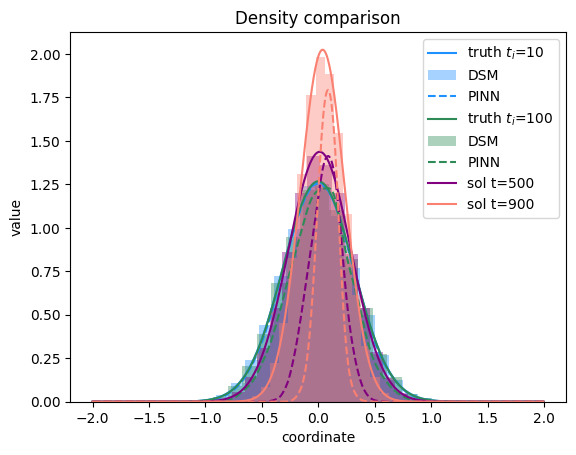

In [227]:
t_step=10
plt.plot(x, dens_num[t_step, :], color="dodgerblue", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="dodgerblue", density=True, alpha=0.4, 
         label='DSM');
plt.plot(x_pinn, dens_pinn[t_step, :],'--', color="dodgerblue", label='PINN')

t_step=100
plt.plot(x, dens_num[t_step, :], color="seagreen", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="seagreen", density=True, alpha=0.4, 
         label='DSM');
plt.plot(x_pinn, dens_pinn[t_step, :],'--', color="seagreen", label='PINN')

t_step=500
plt.plot(x, dens_num[t_step, :], color="purple", label='sol t={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="purple", density=True, alpha=0.4);
plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="purple")
plt.legend();

t_step=900
plt.plot(x, dens_num[t_step, :], color="salmon", label='sol t={}'.format(t_step))
plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="salmon",  density=True, alpha=0.4);
plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="salmon")
plt.xlabel('coordinate')
plt.ylabel('value')
plt.legend();
plt.title('Density comparison');

Let's evaluate errors across statistics: $\mathcal{E}_m (X_i)$ and $\mathcal{E}_v (X_i)$. 

In [15]:
i = 0 
err_mean_xt = (np.linalg.norm(mean_trials[:, :, i] - bmeans, axis=1) / (np.linalg.norm(bmeans))).mean()
err_mean_xt_std = (np.linalg.norm(mean_trials[:, :, i] - bmeans, axis=1) / (np.linalg.norm(bmeans))).std()

err_std_xt = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).mean()
err_std_std = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).std()
print('1D Err(mean(X_t)_NN, mean(X_t)_num): {:.3f}{:.3f}'.format(err_mean_xt, err_mean_xt_std))
print('1D Err(var(X_t)_NN, var(X_t)_num): {:.3f}{:.3f}'.format(err_std_xt, err_std_std))

1D Err(mean(X_t)_NN, mean(X_t)_num): 0.078 0.053
1D Err(var(X_t)_NN, var(X_t)_num):  0.011 0.006


In [19]:
err_mean_xt = np.linalg.norm(np.array(bmeans_pinn) - np.array(bmeans)) / (np.linalg.norm(bmeans))
err_std_xt = np.linalg.norm(np.array(bstds_pinn) - np.array(bstds)) / (np.linalg.norm(bstds))
print('1D Err(mean(X_t)_PINN, mean(X_t)_num): {:.3f}'.format(err_mean_xt))
print('1D Err(var(X_t)_PINN, var(X_t)_num): {:.3f}'.format(err_std_xt))

1D Err(mean(X_t)_PINN, mean(X_t)_num): 0.698
1D Err(var(X_t)_PINN, var(X_t)_num): 0.701
